# Clasificador Bayesiano Ingenuo
## Dalia Yvette Domínguez Jiménez

Importar las librerias necesarias

In [51]:
from os import listdir
from os.path import isfile, join
import cv2
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import inv
from numpy.linalg import det
import math
from scipy.ndimage import gaussian_filter
import seaborn as sns

## Lectura y preprocesamiento

Importar las matrices que contienen las etiquetas de cada imagen del conjunto de entrenamiento

In [2]:
etiquetas = scipy.io.loadmat('ComidaEtiquetada.mat')
etiquetas = etiquetas['Ient']

Obtener el nombre de las imagenes para después leerlas

In [3]:
mypath = 'Comida/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

Leer las imágenes de entrenamiento, suavizarlas con un filtro gausiano y cambiar la forma de las imágenes de $(n,m,3)$ a $(n \times m,3)$

In [18]:
img=np.zeros((600,600,3,7))
images = np.zeros([600*600,4,4])
s=1.2
i=0
for file in onlyfiles[:4]:
    img[:,:,:,i] = cv2.imread(mypath+file)
    img[:,:,:,i] = gaussian_filter(img[:,:,:,i], sigma=s)
    images[:,:,i] = np.column_stack((np.reshape(img[:,:,:,i],(600*600,3)),np.reshape(etiquetas[:,:,i],(600*600))))
    i+=1

Concatenar las instancias (píxeles con 3 atributos RGB) de las 4 imagenes de entrenamiento para tener un conjunto de entrenamiento de $(4  \times n  \times m,3)$

In [5]:
data_train = np.concatenate((images[:,:,0],images[:,:,1],images[:,:,2],images[:,:,3]))
data_train_df=pd.DataFrame(data_train,columns=['R','G','B','Clase'])
data_train_df.head(15) 

,R,G,B,Clase
0,80.0,115.0,155.0,4.0
1,80.0,115.0,155.0,4.0
2,79.0,114.0,154.0,4.0
3,79.0,114.0,154.0,4.0
4,80.0,115.0,155.0,4.0
5,80.0,115.0,155.0,4.0
6,79.0,114.0,154.0,4.0
7,80.0,115.0,155.0,4.0
8,80.0,115.0,155.0,4.0
9,81.0,116.0,156.0,4.0


## Entrenamiento

De acuerdo al teorema de Bayes, sabemos que la probabilidad a posteriori de la clase $C_j$ dado los atributos $[x_1,...,x_n]$, es proporcional a la probabilidad de máxima verosimilitud y la probabilidad a priori de cada clase:

\begin{equation}
    P(C_j | [ {x}_1,..., {x}_n]) = \frac{P([ {x}_1,..., {x}_n]|C_j)P(C_j)}{P( {x}_1,..., {x}_n)} \propto 
   P([ {x}_1,..., {x}_n]|C_j)P(C_j)
\end{equation}

Suponemos que nuestros datos provienen de una distribución multivariable gaussiana:

\begin{equation}
    p(\mathbf{x}|C_j)=\frac{1}{(2 \pi)^{n/2}|\mathbf{\Sigma}_j|^{1/2}} e^{-\frac{1}{2}(\mathbf{x}-\mathbf{m}_j)^T\mathbf{\Sigma}_j^{-1}(\mathbf{x}-\mathbf{m}_j)}
    \label{Ec. gausiana multivariable}
\end{equation}

Aproximando los valores esperados de la media $\mathbf{m}_j$ y la matriz de covarianza $\mathbf{\Sigma}_j$, respectivamente se tiene:

\begin{equation}
    \mathbf{m}_j = \frac{1}{n_j}\sum_{\mathbf{x}\in C_j} \mathbf{x}
\end{equation}

\begin{equation}
    \mathbf{\Sigma}_j = \frac{1}{n_j}\sum_{\mathbf{x}\in C_j} \mathbf{x} \mathbf{x}^T - \mathbf{m}_j\mathbf{m}_j^T
\end{equation}

Donde $n_j$ es el número de vectores muestra para la clase $C_j$.

La exponencial nos permite utilizar el logaritmo natural conservando el orden de los datos, pues el logaritmo es una función monotónicamente creciente:

\begin{equation}
    p(C_j | \mathbf{x}) \propto \ln P(C_j)-\frac{1}{2} \ln |\mathbf{\Sigma}_j|-\frac{1}{2}(\mathbf{x}-\mathbf{m}_j)^T\mathbf{\Sigma}_j^{-1}(\mathbf{x}-\mathbf{m}_j)
\end{equation}


Consideramos que $\mathbf{x}$ pertenece a la clase $C_j$ que maximiza la probabilidad a posteriori.

In [6]:
def decisionMultGauss(x,promedio,cov,Pj):
    dj = np.zeros((x.shape[0],1))
    desv = x-promedio
    inv_cov = inv(cov)
    det_cov = det(cov)
    mul = (np.matmul(desv,inv_cov)*desv).sum(axis=1)
    dj = np.log(Pj)-0.5*np.log(det_cov)-0.5*np.log(mul)
    return dj

In [7]:
class ND_NormalBC:
    
    def fit(self, X, y):
        """
        Estima parámetros: media, matriz de covarianza y probailidad a priori
        """
        self.clases = np.unique(y)  # Nombre de las clases
        self.n_clases = self.clases.size # Número de clases
        self.n_atr = X.shape[-1] # Número de atributos 
        self.m = np.zeros((self.n_clases, self.n_atr)) # Promedios por cada atributo y clase
        self.pc = np.zeros((self.n_clases)) # Estimación a priori de cada clase
        self.cov = np.zeros((self.n_atr,self.n_atr,self.n_clases)) #Matriz de covarianza de cada clase

        n = X.shape[0] # Número total de vectores de entrenamiento (n)
        for i,c in enumerate(self.clases):
            Xc = X[np.where(y == c)] #Atributos x_i que solo son de la clase c
            nc = Xc.shape[0] # Numero de vectores en la clase
            self.pc[i] = nc / n # parametro para la clase
            self.m[i, :] = np.mean(Xc, axis=0) #Promedio por clase
            self.cov[:,:,i] = np.cov(Xc.T) #Matriz de covarianza
            
    def predict_proba(self, x):
        prop = np.zeros((x.shape[0], self.n_clases)) #Para cada vector atributo x' (nuevo), y para cada clase 
        for i in range(self.n_clases):
            #prop[:, i] = decitionMultGauss(x,self.m[i, :],self.cov[:,:,i], self.pc[i]).T
            prop[:, i] = decisionMultGauss(x,self.m[i, :],self.cov[:,:,i], 0.25).T
        return prop
    
    def predict(self, x):
        """
        Predice clase de conjunto de datos
        """
        return self.clases[np.argmax(self.predict_proba(x), axis=1)] #Obtener el maximo de cada vector de atributos
        

Entrenamiento con el conjunto de entrenamiento

In [8]:
nbc = ND_NormalBC()
x_train = data_train[:,:-1]
y_train = data_train[:,-1]
nbc.fit(x_train,y_train)

## Predicción en el conjunto de validación y de entrenamiento

Se preprocesan las imagenes de validación y se acomodan las instancias

In [9]:
a = np.zeros([600*600,3,3])
i=0
for file in onlyfiles[4:]:
    img = cv2.imread(mypath+file)
    img = gaussian_filter(img, sigma=s)
    a[:,:,i] = np.reshape(img,(600*600,3))
    i+=1

Se realizan las predicciónes tanto del conjunto de entrenamiento como de validación

In [10]:
Ipred_val = np.zeros((600,600,3))
Ipred_train = np.zeros((600,600,4))
for i in range(3):
    Ipred_train[:,:,i] =  np.reshape(nbc.predict(images[:,:-1,i]),(600,600)).astype(np.uint8)
    Ipred_val[:,:,i] =  np.reshape(nbc.predict(a[:,:,i]),(600,600)).astype(np.uint8)
Ipred_train[:,:,3] =  np.reshape(nbc.predict(images[:,:-1,3]),(600,600)).astype(np.uint8)

## Resultados

Probabilidades a priori de cada clase

In [48]:
for i, c in enumerate(nbc.clases):
    print("Probabilidad a priori de la clase "+str(c)+":  ",nbc.pc[i])

Probabilidad a priori de la clase 1.0:   0.12031666666666667
Probabilidad a priori de la clase 2.0:   0.07686180555555555
Probabilidad a priori de la clase 3.0:   0.04190208333333333
Probabilidad a priori de la clase 4.0:   0.7609194444444445


Matrices de covarianza

Matriz de covarianza de la clase 1.0:


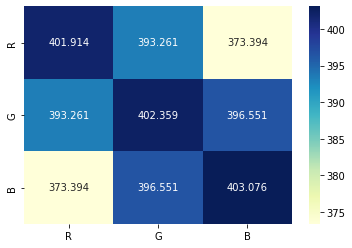

Matriz de covarianza de la clase 2.0:


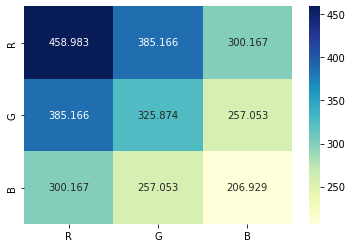

Matriz de covarianza de la clase 3.0:


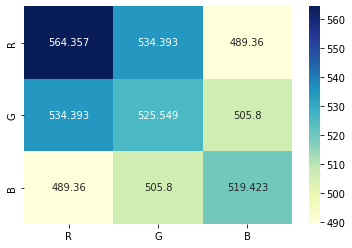

Matriz de covarianza de la clase 4.0:


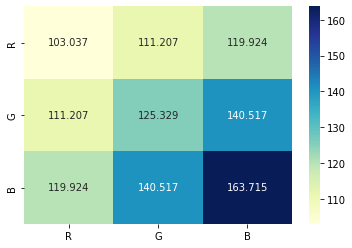

In [71]:
labs = ['R', 'G', 'B']
# fig, axs = plt.subplots(1, 4,figsize=(20,4))
for i, c in enumerate(nbc.clases):
    print("Matriz de covarianza de la clase "+str(c)+":")
    sns.heatmap (nbc.cov[:,:,i], annot = True, fmt = 'g', xticklabels = labs, yticklabels = labs, cmap = 'YlGnBu')
    plt.show ()

In [ ]:
sns.heatmap (cov, annot = True, fmt = 'g', xticklabels = labs, yticklabels = labs, cmap = ' YlGnBu ')
plt.show ()

Promedios RGB de cada clase

In [47]:
for i, c in enumerate(nbc.clases):
    print("Vector de promedios de la clase "+str(c)+":")
    print(nbc.m[i,:])
    print(" ")

Vector de promedios de la clase 1.0:
[117.88641663 155.8097151  188.94545643]
 
Vector de promedios de la clase 2.0:
[227.68673937 228.00019877 228.34770195]
 
Vector de promedios de la clase 3.0:
[43.95546827 53.19806427 58.61169393]
 
Vector de promedios de la clase 4.0:
[ 88.3446972  122.12998803 159.9946273 ]
 


Resultados con el modelo que se programó

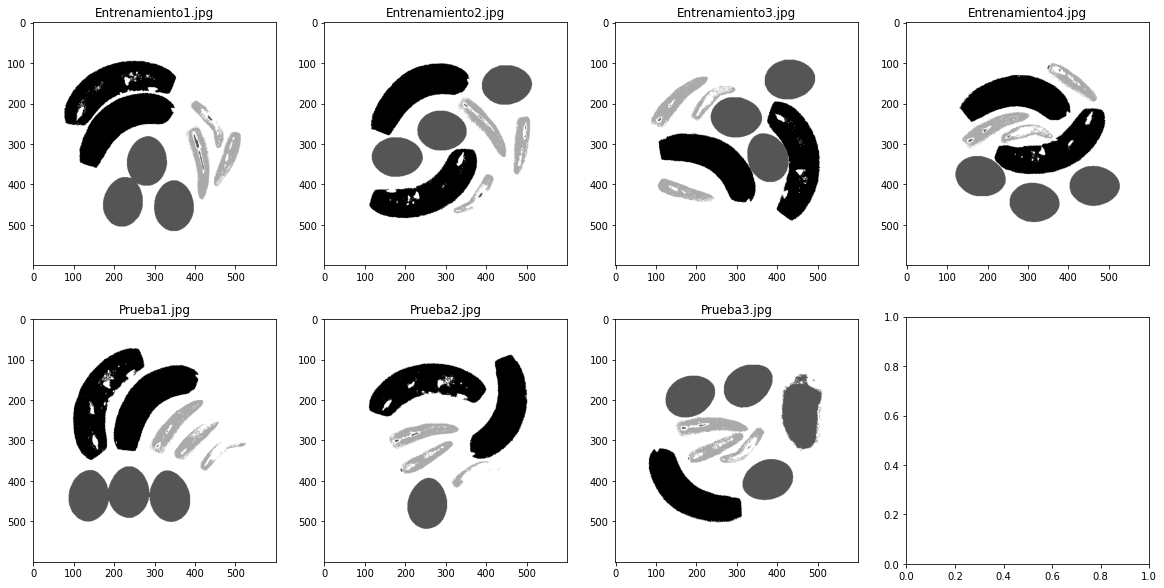

In [11]:
fig, axs = plt.subplots(2, 4,figsize=(20,10))

for i in range(4):
    axs[0, i].imshow(Ipred_train[:,:,i],cmap='gray')
    axs[0, i].set_title(onlyfiles[i])

for i in range(3):
    axs[1, i].imshow(Ipred_val[:,:,i],cmap='gray')
    axs[1, i].set_title(onlyfiles[i+4])

plt.show()

Entrenamiento con sklearn

In [12]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(x_train,y_train)

GaussianNB()

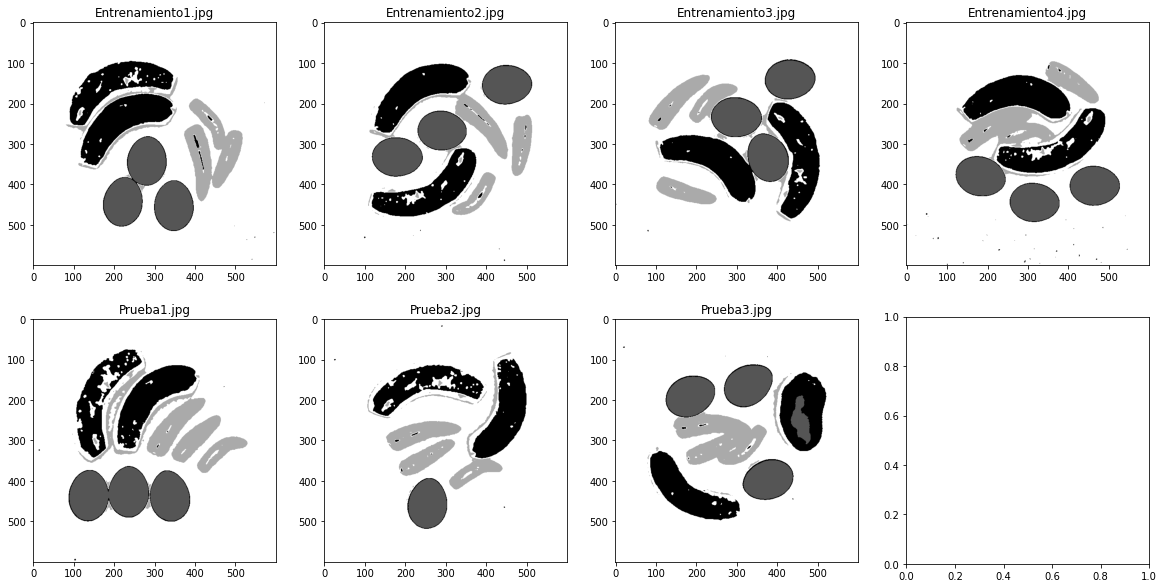

In [13]:
fig, axs = plt.subplots(2, 4,figsize=(20,10))

Ipred_val = np.zeros((600,600,3))
Ipred_train = np.zeros((600,600,4))

for i in range(3):
    Ipred_train[:,:,i] =  np.reshape(gnb.predict(images[:,:-1,i]),(600,600)).astype(np.uint8)
    Ipred_val[:,:,i] =  np.reshape(gnb.predict(a[:,:,i]),(600,600)).astype(np.uint8)
Ipred_train[:,:,3] =  np.reshape(gnb.predict(images[:,:-1,3]),(600,600)).astype(np.uint8)

for i in range(4):
    axs[0, i].imshow(Ipred_train[:,:,i],cmap='gray')
    axs[0, i].set_title(onlyfiles[i])

for i in range(3):
    axs[1, i].imshow(Ipred_val[:,:,i],cmap='gray')
    axs[1, i].set_title(onlyfiles[i+4])


plt.show()